# Analiza danych Airbnb: Amsterdam i Madryt




# 1. Cel projektu
Celem niniejszego projektu jest analiza danych pochodzących z platformy Airbnb oraz budowa modeli uczenia maszynowego służących do prognozowania ceny wynajmu nieruchomości. Analiza została przeprowadzona na przykładzie dwóch europejskich miast: Amsterdamu oraz Madrytu.

In [17]:
!pip -q install xgboost shap

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

import matplotlib.pyplot as plt


# 2. Źródło danych
W projekcie wykorzystano otwarte dane udostępnione przez serwis Inside Airbnb, zawierające szczegółowe informacje o ofertach wynajmu krótkoterminowego:

**Amsterdam** – plik listings.csv.gz

**Madryt** – plik listings.csv.gz

Zbiory danych obejmują zarówno zmienne liczbowe (np. cena, liczba noclegów, liczba opinii), jak i zmienne kategoryczne (np. typ nieruchomości, dzielnica, rodzaj pokoju).

In [18]:
AMSTERDAM_URL = "https://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2025-09-11/data/listings.csv.gz"
MADRID_URL = "https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2025-09-14/data/listings.csv.gz"

amsterdam_raw = pd.read_csv(AMSTERDAM_URL)
madrid_raw = pd.read_csv(MADRID_URL)

print("Amsterdam:", amsterdam_raw.shape)
print("Madrid   :", madrid_raw.shape)
amsterdam_raw.head()

Amsterdam: (10480, 79)
Madrid   : (25000, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,27886,https://www.airbnb.com/rooms/27886,20250911031321,2025-09-11,city scrape,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,...,4.93,4.90,4.78,0363 974D 4986 7411 88D8,f,1,0,1,0,1.87
1,28871,https://www.airbnb.com/rooms/28871,20250911031321,2025-09-11,city scrape,Comfortable double room,Basic bedroom in the center of Amsterdam.,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,...,4.94,4.93,4.83,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.99
2,29051,https://www.airbnb.com/rooms/29051,20250911031321,2025-09-11,city scrape,Comfortable single / double room,This room can also be rented as a single or a ...,the street is quite lively especially on weeke...,https://a0.muscache.com/pictures/162009/bd6be2...,124245,...,4.92,4.87,4.79,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,4.81
3,44391,https://www.airbnb.com/rooms/44391,20250911031321,2025-09-11,previous scrape,Quiet 2-bedroom Amsterdam city centre apartment,Guests greatly appreciate the unique location ...,The appartment is located in the city centre. ...,https://a0.muscache.com/pictures/97741545/3900...,194779,...,4.90,4.68,4.50,0363 E76E F06A C1DD 172C,f,1,1,0,0,0.23
4,48373,https://www.airbnb.com/rooms/48373,20250911031321,2025-09-11,previous scrape,Cozy family home in Amsterdam South,Charming modern apartment in the quiet and gre...,Apartment is located between Amsterdamse Bos a...,https://a0.muscache.com/pictures/miso/Hosting-...,220434,...,5.00,4.60,5.00,0363 4A2B A6AD 0196 F684,f,1,1,0,0,0.19


In [19]:
def dataset_report(df: pd.DataFrame, name: str) -> None:
    print(f"=== {name} ===")
    print(f"• OBSERWACJE (wiersze): {df.shape[0]:,}")
    print(f"• ZMIENNE (kolumny):    {df.shape[1]:,}")
    print(f"• PAMIĘĆ:              {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print()

dataset_report(amsterdam_raw, "Amsterdam")
dataset_report(madrid_raw, "Madrid")

=== Amsterdam ===
• OBSERWACJE (wiersze): 10,480
• ZMIENNE (kolumny):    79
• PAMIĘĆ:              41.8 MB

=== Madrid ===
• OBSERWACJE (wiersze): 25,000
• ZMIENNE (kolumny):    79
• PAMIĘĆ:              95.7 MB



# 3. Przygotowanie danych
Proces przygotowania danych obejmował następujące etapy:
- oczyszczenie kolumny price (usunięcie symboli waluty i konwersja do formatu
numerycznego),
- selekcję istotnych cech numerycznych i kategorycznych,
obsługę brakujących wartości:
  - dla cech numerycznych zastosowano imputację medianą,
  - dla cech kategorycznych zastosowano imputację najczęściej występującą wartością,
- kodowanie zmiennych kategorycznych przy użyciu metody One-Hot Encoding,
podział danych na zbiór treningowy i testowy w proporcji 80% / 20%.
Cały proces przetwarzania danych został zaimplementowany z wykorzystaniem Pipeline oraz ColumnTransformer, co zapobiega wyciekowi danych (data leakage).

In [20]:
def parse_price_to_float(s: pd.Series) -> pd.Series:

    return pd.to_numeric(
        s.astype(str).str.replace(r"[\$,€\s,]", "", regex=True),
        errors="coerce"
    )

def prepare_base(df: pd.DataFrame, city: str) -> pd.DataFrame:
    out = df.copy()
    out["price_num"] = parse_price_to_float(out["price"])
    out = out.dropna(subset=["price_num"]).copy()

    q01 = out["price_num"].quantile(0.01)
    q99 = out["price_num"].quantile(0.99)
    out = out[(out["price_num"] >= q01) & (out["price_num"] <= q99)].copy()


    if "host_is_superhost" in out.columns:
        out["host_is_superhost"] = out["host_is_superhost"].map({"t": True, "f": False})

    out["city"] = city
    return out

amsterdam = prepare_base(amsterdam_raw, "Amsterdam")
madrid = prepare_base(madrid_raw, "Madrid")

print("Amsterdam cleaned:", amsterdam.shape, "price range:", (amsterdam.price_num.min(), amsterdam.price_num.max()))
print("Madrid cleaned   :", madrid.shape, "price range:", (madrid.price_num.min(), madrid.price_num.max()))

Amsterdam cleaned: (5760, 81) price range: (66.0, 990.0)
Madrid cleaned   : (18602, 81) price range: (21.0, 790.0)


=== Amsterdam (price_num) ===
count    5760.000000
mean      254.518576
std       137.875573
min        66.000000
25%       162.000000
50%       222.000000
75%       309.000000
max       990.000000
Name: price_num, dtype: float64

Missing (top 15):
neighbourhood_group_cleansed    1.000000
calendar_updated                1.000000
host_neighbourhood              0.756771
neighbourhood                   0.532639
neighborhood_overview           0.532639
host_about                      0.470660
host_response_time              0.145660
host_response_rate              0.145660
host_location                   0.116493
review_scores_checkin           0.109896
review_scores_value             0.109896
review_scores_location          0.109896
review_scores_communication     0.109896
reviews_per_month               0.109896
review_scores_cleanliness       0.109896
dtype: float64


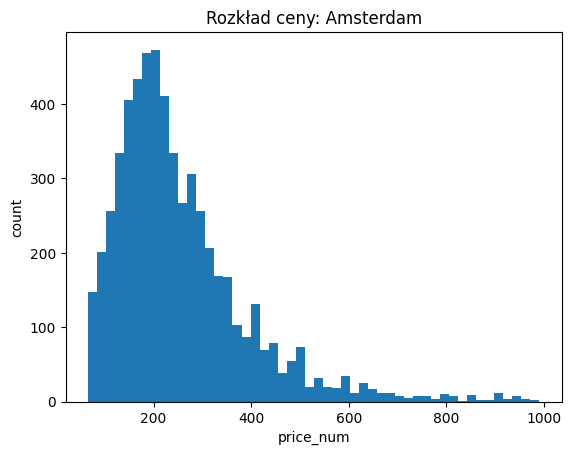

=== Madrid (price_num) ===
count    18602.000000
mean       132.401355
std         96.637290
min         21.000000
25%         71.000000
50%        110.000000
75%        161.000000
max        790.000000
Name: price_num, dtype: float64

Missing (top 15):
calendar_updated               1.000000
host_neighbourhood             0.711375
neighbourhood                  0.575314
neighborhood_overview          0.575314
license                        0.550855
host_about                     0.483443
host_location                  0.340340
review_scores_checkin          0.159553
review_scores_cleanliness      0.159553
review_scores_accuracy         0.159499
first_review                   0.159499
review_scores_communication    0.159499
reviews_per_month              0.159499
review_scores_value            0.159499
review_scores_location         0.159499
dtype: float64


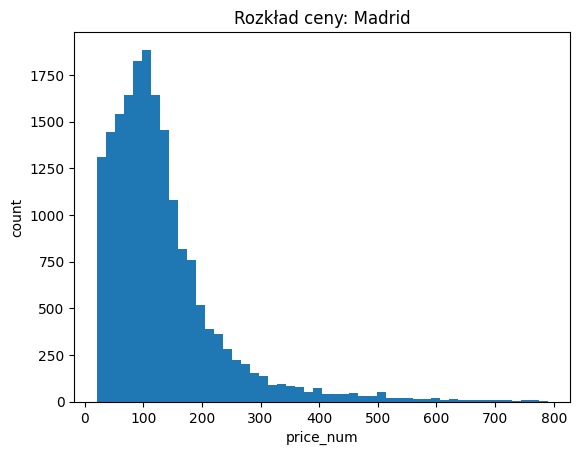

In [21]:
def quick_eda(df: pd.DataFrame, name: str) -> None:
    print(f"=== {name} (price_num) ===")
    print(df["price_num"].describe())
    print("\nMissing (top 15):")
    print(df.isna().mean().sort_values(ascending=False).head(15))
    plt.figure()
    plt.hist(df["price_num"], bins=50)
    plt.title(f"Rozkład ceny: {name}")
    plt.xlabel("price_num")
    plt.ylabel("count")
    plt.show()

quick_eda(amsterdam, "Amsterdam")
quick_eda(madrid, "Madrid")

In [22]:
CAND_NUM = [
    "accommodates", "bedrooms", "beds", "bathrooms", "minimum_nights",
    "number_of_reviews", "reviews_per_month", "availability_365",
    "latitude", "longitude",
]
CAND_CAT = [
    "room_type", "property_type", "neighbourhood_cleansed",
    "host_is_superhost", "instant_bookable",
]

def select_features(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    num_cols = [c for c in CAND_NUM if c in df.columns]
    cat_cols = [c for c in CAND_CAT if c in df.columns]
    return num_cols, cat_cols

am_num, am_cat = select_features(amsterdam)
md_num, md_cat = select_features(madrid)

print("Amsterdam num:", am_num)
print("Amsterdam cat:", am_cat)
print("Madrid num   :", md_num)
print("Madrid cat   :", md_cat)

Amsterdam num: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'latitude', 'longitude']
Amsterdam cat: ['room_type', 'property_type', 'neighbourhood_cleansed', 'host_is_superhost', 'instant_bookable']
Madrid num   : ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'latitude', 'longitude']
Madrid cat   : ['room_type', 'property_type', 'neighbourhood_cleansed', 'host_is_superhost', 'instant_bookable']


# 5. Ocena jakości modeli
Jakość predykcji modeli została oceniona przy użyciu następujących metryk:

**MAE (Mean Absolute Error)**

**RMSE (Root Mean Squared Error)**

**R² (współczynnik determinacji)**

Metryki obliczono osobno dla każdego miasta i każdej metody modelowania, co umożliwia bezpośrednie porównanie wyników.

In [23]:
def build_preprocessor(num_cols: List[str], cat_cols: List[str]) -> ColumnTransformer:
    num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])
    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop"
    )

def evaluate(y_true, y_pred) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

# 4. Budowa modeli
Dla każdego miasta wytrenowano dwa modele regresyjne:

*4.1 Regresja liniowa (Ridge Regression)*

Model regresji liniowej z regularyzacją typu Ridge został wykorzystany jako model bazowy, umożliwiający ocenę prostych zależności liniowych pomiędzy cechami a ceną.

*4.2 XGBoost Regressor*

Model XGBoost (Extreme Gradient Boosting) oparty na drzewach decyzyjnych, pozwalający na modelowanie złożonych, nieliniowych relacji oraz interakcji pomiędzy zmiennymi.

In [24]:
@dataclass
class CityResult:
    city: str
    n_rows: int
    feature_num: List[str]
    feature_cat: List[str]
    linear_metrics: Dict[str, float]
    xgb_metrics: Dict[str, float]
    linear_model: Pipeline
    xgb_model: Pipeline
    X_test_raw: pd.DataFrame
    y_test: pd.Series

In [25]:
def train_for_city(df: pd.DataFrame, num_cols: List[str], cat_cols: List[str], city: str) -> CityResult:
    if not num_cols and not cat_cols:
        raise ValueError(f"{city}: brak cech wejściowych po selekcji (sprawdź nazwy kolumn).")

    X = df[num_cols + cat_cols].copy()
    y = df["price_num"].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pre = build_preprocessor(num_cols, cat_cols)

    linear = Pipeline(steps=[
        ("pre", pre),
        ("model", Ridge(alpha=1.0, random_state=42))
    ])

    xgb = Pipeline(steps=[
        ("pre", pre),
        ("model", XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.0,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        ))
    ])

    linear.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    lin_pred = linear.predict(X_test)
    xgb_pred = xgb.predict(X_test)

    return CityResult(
        city=city,
        n_rows=len(df),
        feature_num=num_cols,
        feature_cat=cat_cols,
        linear_metrics=evaluate(y_test, lin_pred),
        xgb_metrics=evaluate(y_test, xgb_pred),
        linear_model=linear,
        xgb_model=xgb,
        X_test_raw=X_test,
        y_test=y_test
    )

am_res = train_for_city(amsterdam, am_num, am_cat, "Amsterdam")
md_res = train_for_city(madrid, md_num, md_cat, "Madrid")

am_res.linear_metrics, am_res.xgb_metrics, md_res.linear_metrics, md_res.xgb_metrics

({'MAE': 64.95832476857498,
  'RMSE': 90.89541019723964,
  'R2': 0.5416613214634809},
 {'MAE': 59.272927833928, 'RMSE': 86.66225192242807, 'R2': 0.5833584861880187},
 {'MAE': 43.38078452866759,
  'RMSE': 69.88466753259617,
  'R2': 0.46149765516835384},
 {'MAE': 35.19433144498211,
  'RMSE': 58.60415949693568,
  'R2': 0.6213127569062327})

In [26]:
results = pd.DataFrame([
    {"City":"Amsterdam","Model":"Linear (Ridge)", **am_res.linear_metrics},
    {"City":"Amsterdam","Model":"XGBoost", **am_res.xgb_metrics},
    {"City":"Madrid","Model":"Linear (Ridge)", **md_res.linear_metrics},
    {"City":"Madrid","Model":"XGBoost", **md_res.xgb_metrics},
])
results

,City,Model,MAE,RMSE,R2
0,Amsterdam,Linear (Ridge),64.958325,90.895410,0.541661
1,Amsterdam,XGBoost,59.272928,86.662252,0.583358
2,Madrid,Linear (Ridge),43.380785,69.884668,0.461498
3,Madrid,XGBoost,35.194331,58.604159,0.621313


# 6. Interpretowalność modeli (XAI)
Dla modelu XGBoost zastosowano metodę SHAP (SHapley Additive exPlanations), która pozwala:
określić, które cechy mają największy wpływ na przewidywaną cenę,
analizować wpływ poszczególnych zmiennych na wynik modelu,
zwiększyć przejrzystość i zrozumiałość modelu.
Ze względu na ograniczenia pamięci w środowisku Google Colab, analiza SHAP została przeprowadzona na ograniczonej liczbie obserwacji.



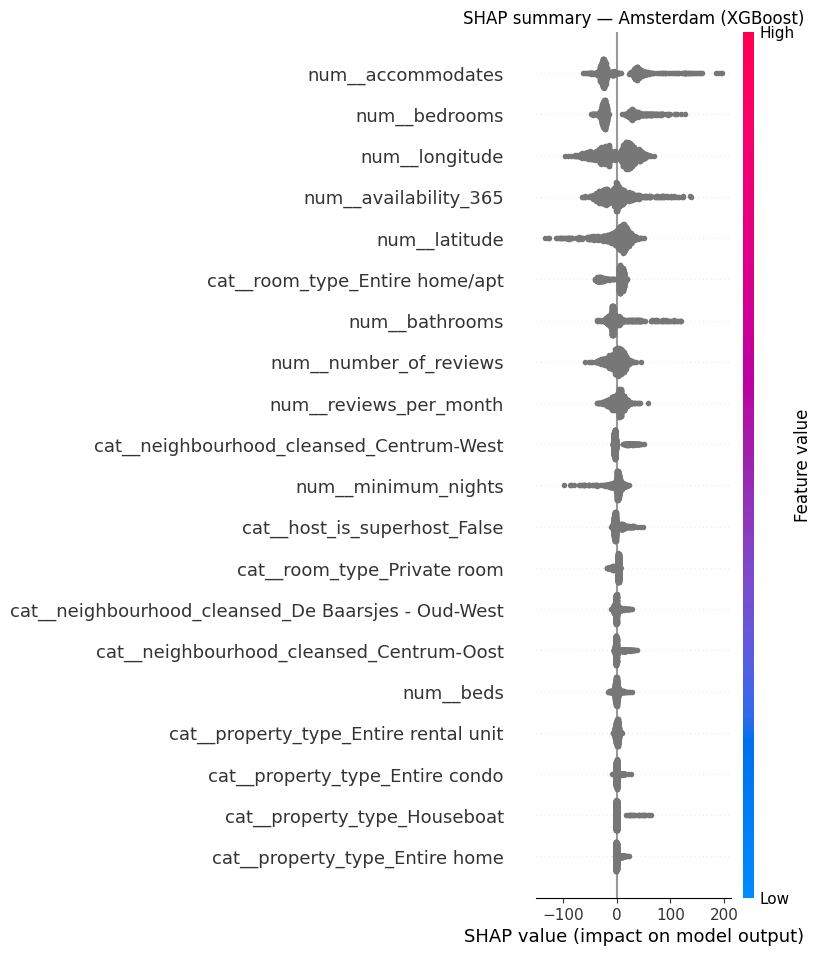

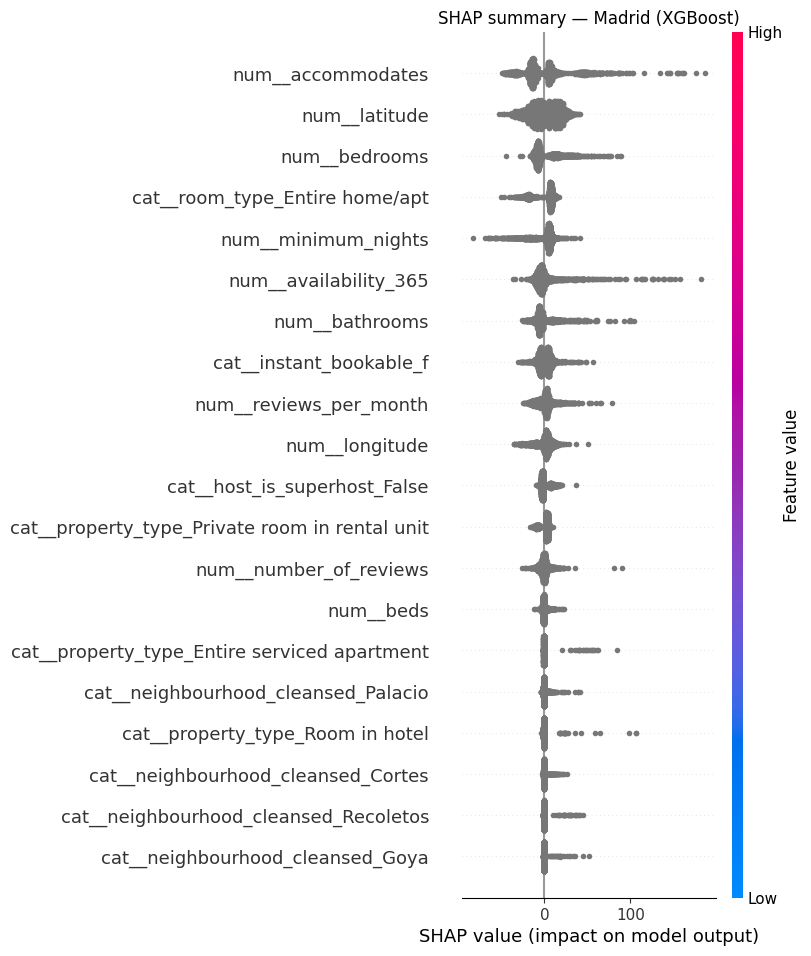

Top SHAP — Amsterdam


,mean(|SHAP|)
num__accommodates,33.706413
num__bedrooms,29.900225
num__longitude,26.766579
num__availability_365,19.656898
num__latitude,17.988199
cat__room_type_Entire home/apt,12.950031
num__bathrooms,12.681470
num__number_of_reviews,10.426528
num__reviews_per_month,9.881396
cat__neighbourhood_cleansed_Centrum-West,6.612213



Top SHAP — Madrid


,mean(|SHAP|)
num__accommodates,19.656580
num__latitude,13.337839
num__bedrooms,11.578860
cat__room_type_Entire home/apt,10.541062
num__minimum_nights,8.981959
num__availability_365,8.768463
num__bathrooms,8.208370
cat__instant_bookable_f,6.561250
num__reviews_per_month,6.444294
num__longitude,6.312380


In [27]:
import shap
shap.initjs()

def shap_for_city(res: CityResult, max_rows: int = 2000):
    pre = res.xgb_model.named_steps["pre"]
    model = res.xgb_model.named_steps["model"]


    X_test_raw = res.X_test_raw.copy()
    X_trans = pre.transform(X_test_raw)


    feature_names = []
    if hasattr(pre, "get_feature_names_out"):
        feature_names = list(pre.get_feature_names_out())
    else:
        feature_names = [f"f{i}" for i in range(X_trans.shape[1])]


    if X_trans.shape[0] > max_rows:
        X_trans_small = X_trans[:max_rows]
    else:
        X_trans_small = X_trans

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_trans_small)


    plt.figure()
    shap.summary_plot(shap_values, X_trans_small, feature_names=feature_names, show=False)
    plt.title(f"SHAP summary — {res.city} (XGBoost)")
    plt.show()


    mean_abs = np.abs(shap_values).mean(axis=0)
    top = pd.Series(mean_abs, index=feature_names).sort_values(ascending=False).head(15)
    return top

am_top = shap_for_city(am_res)
md_top = shap_for_city(md_res)

print("Top SHAP — Amsterdam")
display(am_top.to_frame("mean(|SHAP|)"))
print("\nTop SHAP — Madrid")
display(md_top.to_frame("mean(|SHAP|)"))

# 8. Wnioski
Na podstawie przeprowadzonej analizy danych Airbnb dla miast Amsterdam i Madryt można sformułować następujące wnioski:

1. **Model XGBoost osiąga lepsze wyniki predykcyjne niż regresja liniowa**
W obu miastach model XGBoost uzyskał niższe wartości błędów MAE i RMSE oraz wyższy współczynnik R² w porównaniu do modelu regresji liniowej. Świadczy to o tym, że zależność pomiędzy cechami ofert a ceną wynajmu ma w dużej mierze charakter nieliniowy.

2. **Cechy lokalizacyjne i typ nieruchomości mają kluczowy wpływ na cenę**
Analiza SHAP wykazała, że do najważniejszych czynników wpływających na cenę należą: dzielnica (neighbourhood), typ pokoju (room type), rodzaj nieruchomości (property type) oraz liczba minimalnych noclegów. Potwierdza to istotną rolę lokalizacji i charakteru oferty w kształtowaniu cen na rynku najmu krótkoterminowego.

3. **Różnice pomiędzy miastami wpływają na strukturę ważnych cech**
Chociaż ogólne trendy są podobne, znaczenie poszczególnych zmiennych różni się pomiędzy Amsterdamem a Madrytem. Wskazuje to na konieczność budowy i trenowania modeli oddzielnie dla każdego rynku lokalnego, zamiast stosowania jednego uniwersalnego modelu.

4. **Pipeline i automatyczna obróbka danych zwiększają wiarygodność wyników**
Zastosowanie Pipeline oraz ColumnTransformer pozwoliło na spójne przetwarzanie danych oraz eliminację ryzyka wycieku informacji ze zbioru testowego. Takie podejście jest szczególnie istotne w projektach analitycznych i badaniach akademickich.

5. **Metody Explainable AI zwiększają transparentność modeli**
Wykorzystanie metody SHAP umożliwiło interpretację wyników modelu XGBoost oraz zrozumienie wpływu poszczególnych cech na predykcję ceny. Pokazuje to, że nawet złożone modele mogą być analizowane w sposób przejrzysty i zrozumiały.

6. **Ograniczenia analizy**
Analiza opiera się na danych historycznych i nie uwzględnia czynników zewnętrznych, takich jak sezonowość, wydarzenia lokalne czy zmiany regulacyjne. Dodatkowo, analiza SHAP została przeprowadzona na ograniczonej liczbie obserwacji ze względu na ograniczenia pamięci środowiska Google Colab.

Podsumowując, zastosowanie modeli uczenia maszynowego, w szczególności XGBoost w połączeniu z metodami XAI, stanowi skuteczne narzędzie do analizy i prognozowania cen najmu krótkoterminowego, jednak najlepsze rezultaty osiąga się przy uwzględnieniu specyfiki lokalnego rynku.